In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib_venn import venn2

import qtl.annotation
import qtl.genotype as gt
import qtl.map
import qtl.torus
import qtl.plot
import qtl.locusplot
import style

In [2]:
annot = qtl.annotation.Annotation('data/gencode.v26.GRCh38.genes.gtf', verbose=False)
sample_df = pd.read_csv('data/GTEx_Analysis_v8_RNAseq_samples.txt', sep='\t')
sample_s = sample_df[sample_df['has_genotype']].groupby('tissue_id').apply(lambda x: x['sample_id'].tolist())
sample_s = sample_s[sample_s.apply(len)>=70]
size_s = sample_s.apply(len)

vcf = 'data/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.vcf.gz'

pairs = np.array([
    ['Brain_Cortex', 'Neurons'],
    ['Breast_Mammary_Tissue', 'Adipocytes'],
    ['Colon_Transverse', 'Epithelial_cells'],
    ['Heart_Left_Ventricle', 'Myocytes'],
    ['Liver', 'Hepatocytes'],
    ['Skin_Sun_Exposed_Lower_leg', 'Keratinocytes'],
    ['Whole_Blood', 'Neutrophils'],
])
tissues = pairs[:,0]

### Panel A: ieQTL & isQTL discovery

In [3]:
ieqtl_summary_df = pd.DataFrame(index=tissues, columns=['num_ieqtl', 'num_egenes', 'num_detected'])
isqtl_summary_df = pd.DataFrame(index=tissues, columns=['num_isqtl', 'num_sgenes', 'num_detected'])

for tissue_id, celltype in pairs:

    # ieGenes at 0.05 FDR, subset by protein coding and lincRNA genes
    iegenes_df = pd.read_csv('data/GTEx_Analysis_v8_ieQTL/{}.{}.ieQTL.eigenMT.annotated.txt.gz'.format(tissue_id, celltype), sep='\t', index_col=1)
    iegenes_df = iegenes_df[(iegenes_df['pval_adj_bh']<=0.05) & iegenes_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    ieqtl_summary_df.loc[tissue_id, 'num_ieqtl'] = iegenes_df.shape[0]
    
    # eGenes
    egenes_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL/{}.v8.egenes.txt.gz'.format(tissue_id), sep='\t', index_col=0)
    egenes_df['biotype'] = egenes_df.index.map(lambda x: annot.gene_dict[x].type)
    egenes_df = egenes_df[(egenes_df['qval']<=0.05) & egenes_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    ieqtl_summary_df.loc[tissue_id, 'num_egenes'] = iegenes_df.index.isin(egenes_df.index).sum()

    # genes detected
    phenotype_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL_expression_matrices/{}.v8.normalized_expression.bed.gz'.format(tissue_id),
                               sep='\t', usecols=['#chr', 'start', 'end', 'gene_id'], index_col=3)
    phenotype_df['biotype'] = phenotype_df.index.map(lambda x: annot.gene_dict[x].type)
    phenotype_df = phenotype_df[phenotype_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    ieqtl_summary_df.loc[tissue_id, 'num_detected'] = phenotype_df.shape[0]
    
    # isGenes at 0.05 FDR, subset by protein coding and lincRNA genes
    isgenes_df = pd.read_csv('data/GTEx_Analysis_v8_isQTL/{}.{}.isQTL.eigenMT.annotated.txt.gz'.format(tissue_id, celltype), sep='\t', index_col=1)
    isgenes_df = isgenes_df[(isgenes_df['pval_adj_bh']<=0.05) & isgenes_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    isqtl_summary_df.loc[tissue_id, 'num_isqtl'] = isgenes_df.shape[0]

    # sGenes
    sgenes_df = pd.read_csv('data/GTEx_Analysis_v8_sQTL/{}.v8.sgenes.txt.gz'.format(tissue_id), sep='\t', index_col=0)
    sgenes_df['biotype'] = sgenes_df['gene_id'].apply(lambda x: annot.gene_dict[x].type)
    sgenes_df = sgenes_df[(sgenes_df['qval']<=0.05) & sgenes_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    isqtl_summary_df.loc[tissue_id, 'num_sgenes'] = isgenes_df.index.isin(sgenes_df['gene_id']).sum()

    # alternatively spliced genes detected
    group_s = pd.read_csv('data/GTEx_Analysis_v8_sQTL_groups/{}.leafcutter.phenotype_groups.txt'.format(tissue_id),
                      sep='\t', index_col=0, squeeze=True, header=None)
    group_s = group_s[group_s.apply(lambda x: annot.gene_dict[x].type in ['protein_coding', 'lincRNA'])]
    isqtl_summary_df.loc[tissue_id, 'num_detected'] = group_s.value_counts().shape[0]


ieqtl_summary_df['ieqtl_only'] = ieqtl_summary_df['num_ieqtl'] - ieqtl_summary_df['num_egenes']
ieqtl_summary_df['samples'] = size_s[ieqtl_summary_df.index]
ieqtl_summary_df = ieqtl_summary_df.sort_values('samples')

isqtl_summary_df['isqtl_only'] = isqtl_summary_df['num_isqtl'] - isqtl_summary_df['num_sgenes']
isqtl_summary_df['samples'] = size_s[isqtl_summary_df.index]
isqtl_summary_df = isqtl_summary_df.sort_values('samples')

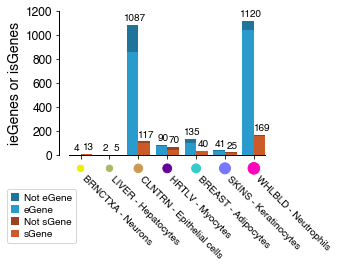

In [4]:
ax = qtl.plot.setup_figure(3, 2, xspace=[0.75,1.5], yspace=[1.5,0.5])

x = np.arange(ieqtl_summary_df.shape[0])
ax.set_xticks(x)
w = 0.4
args = {'width': w}

ax.bar(x-w/2, ieqtl_summary_df['ieqtl_only'], bottom=ieqtl_summary_df['num_egenes'],
       color=style.qtl_color_s['eqtl_dark'], label='Not eGene', **args)
ax.bar(x-w/2, ieqtl_summary_df['num_egenes'], 
       color=style.qtl_color_s['eqtl'], label='eGene', **args)

ax.bar(x+w/2, isqtl_summary_df['isqtl_only'], bottom=isqtl_summary_df['num_sgenes'],
       color=style.qtl_color_s['sqtl_dark'], label='Not sGene', **args)
ax.bar(x+w/2, isqtl_summary_df['num_sgenes'], **args,
       color=style.qtl_color_s['sqtl'], label='sGene')

qtl.plot.format_plot(ax, fontsize=12)

xtl = style.colors_df.loc[ieqtl_summary_df.index, 'tissue_abbrv'] \
    + ' - ' + ieqtl_summary_df.index.map(dict(pairs)).str.replace('_',' ')
ax.set_xticklabels(xtl, rotation=-45, ha='left')
ax.tick_params(axis='x', which='major', pad=15, labelsize=10)
ax.set_yticks(np.arange(0,1500,200))
ylim = [0,1200]

d = ylim[1]-ylim[0]
s = 1.09
b = ylim[1] - s*d
ax.set_ylim(ylim)
ax.scatter(x, b*np.ones(len(x)), s=isqtl_summary_df['samples']/5, 
           c=style.colors_df.loc[ieqtl_summary_df.index, 'color_hex'], clip_on=False)
ax.set_ylabel('ieGenes or isGenes', fontsize=14)

# plot numbers
for i in range(7):
    ax.text(i-w/2+0.05, 0.015*d+ieqtl_summary_df['num_ieqtl'][i],
            ieqtl_summary_df['num_ieqtl'][i], rotation=0, va='bottom', ha='center')
    ax.text(i+w/2+0.05, 0.015*d+isqtl_summary_df['num_isqtl'][i],
            isqtl_summary_df['num_isqtl'][i], rotation=0, va='bottom', ha='center')

leg = ax.legend(loc='upper right', bbox_to_anchor=(0.1,-0.2), handletextpad=0.5, 
                markerscale=0.5, fontsize=10, labelspacing=0.3,
                handlelength=0.75, handleheight=0.75)
ax.spines['bottom'].set_smart_bounds(True)
ax.spines['left'].set_position(('outward', 0))
plt.savefig('pdfs/Fig7A_ixQTL_summary_combined.pdf')

### Panel B: functional enrichment

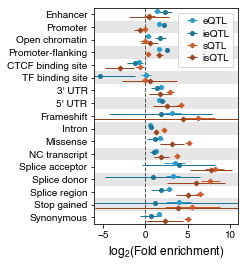

In [5]:
# load Torus results
torus_eqtl_df =  qtl.torus.load('data/Fig7B_Whole_Blood_eQTLs.torus_enrichment.txt', log2=True)
torus_ieqtl_df = qtl.torus.load('data/Fig7B_Whole_Blood_Neutrophil_ieQTLs.torus_enrichment.txt', log2=True)
torus_sqtl_df =  qtl.torus.load('data/Fig7B_Whole_Blood_sQTLs.torus_enrichment.txt', log2=True)
torus_isqtl_df = qtl.torus.load('data/Fig7B_Whole_Blood_Neutrophil_isQTLs.torus_enrichment.txt', log2=True)

eargs =  {'fmt':'.', 'ms':8,   'lw':1, 'clip_on':False, 'label':'eQTL',  'c':style.qtl_color_s['eqtl']}
ieargs = {'fmt':'.', 'ms':8,   'lw':1, 'clip_on':False, 'label':'ieQTL', 'c':style.qtl_color_s['eqtl_dark']}
sargs =  {'fmt':'D', 'ms':3.5, 'lw':1, 'clip_on':False, 'label':'sQTL',  'c':style.qtl_color_s['sqtl']}
isargs = {'fmt':'D', 'ms':3.5, 'lw':1, 'clip_on':False, 'label':'isQTL', 'c':style.qtl_color_s['sqtl_dark']}

ax = qtl.plot.plot_effects([torus_eqtl_df, torus_ieqtl_df, torus_sqtl_df, torus_isqtl_df],
                           [eargs, ieargs, sargs, isargs], 
                           xspace=[1.25,2,0.25], yspace=[0.75,3,0.25], xlim=[-6,11],
                           xlabel='log$\mathregular{_{2}}$(Fold enrichment)')
ax.set_xticks(np.arange(-5,15,5))
ax.legend(loc='upper right', ncol=1, labelspacing=0.33, 
           columnspacing=1, handletextpad=0)
plt.savefig('pdfs/Fig7B_ieQTL_isQTL_Whole_Blood_Torus.pdf')

### Panel C: eGene enrichment

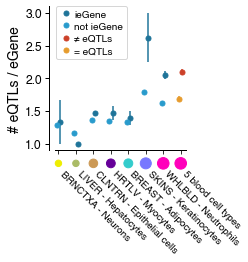

In [6]:
summary_df = pd.read_csv('data/Fig7C_ieQTL_indep_enrichment_summary.txt', sep='\t', index_col=0)
summary_df = summary_df.applymap(lambda x: 
                 [np.float64(i) for i in x.replace('[','').replace(']','').split(', ')]
             if not pd.isnull(x) else x)
summary_df = summary_df.loc[size_s[summary_df.index].sort_values().index]  # sort by sample size

ax = qtl.plot.setup_figure(2,2, xspace=[0.75,1], yspace=[1.5,0.25])
x = np.arange(summary_df.shape[0])

args = [
    {'fmt':'.', 'ms':10, 'lw':1.5, 'clip_on':False, 'c':style.qtl_color_s['eqtl_dark'], 'label':'ieGene'},
    {'fmt':'.', 'ms':10, 'lw':1.5, 'clip_on':False, 'c':style.qtl_color_s['eqtl'], 'label':'not ieGene'},
]

offset = [0.1, -0.1]
for k,c in enumerate(['num_indep_ieqtl', 'num_indep_not_ieqtl']):
    df = pd.DataFrame([np.array(i) for i in summary_df[c].values], index=summary_df.index)
    mean_col = df.columns[0]
    ci_cols = df.columns[1:]
    delta = (df[ci_cols].T - df[mean_col]).abs()
    ax.errorbar(x+offset[k], df[mean_col], yerr=delta.values, **args[k])

# cell type specific eQTLs from [Peters et al., PLoS Genetics, 2016]
args = {'fmt':'.', 'ms':10, 'lw':1.5, 'clip_on':False, 'c':hsv_to_rgb([0.025, 0.8, 0.8]), 'label':'≠ eQTLs'}
c = np.array(summary_df.loc['Whole_Blood', 'num_indep_ceqtl'])
delta = np.abs(c[1:]-c[0])
ax.errorbar(7.1, c[0], yerr=delta.reshape(-1,1), **args)
args = {'fmt':'.', 'ms':10, 'lw':1.5, 'clip_on':False, 'c':hsv_to_rgb([0.1, 0.8, 0.9  ]), 'label':'= eQTLs'}
c = np.array(summary_df.loc['Whole_Blood', 'num_indep_not_ceqtl'])
delta = np.abs(c[1:]-c[0])
ax.errorbar(6.9, c[0], yerr=delta.reshape(-1,1), **args)
   
ax.set_ylabel('# eQTLs / eGene', fontsize=14)

ylim = ax.get_ylim()
s = 1.09
b = ylim[1] - s*np.diff(ylim)
ax.set_ylim(ylim)
x = np.arange(summary_df.shape[0]+1)
ix = summary_df.index.tolist() + ['Whole_Blood']
ax.scatter(x, b*np.ones(len(x)), s=size_s[ix]/5, 
           c=style.colors_df.loc[ix, 'color_hex'], clip_on=False)

xtl = style.colors_df.loc[summary_df.index, 'tissue_abbrv'] +' - '+ summary_df.index.map(dict(pairs)).str.replace('_',' ')
ax.set_xticks(np.arange(summary_df.shape[0]+1))
ax.set_xticklabels(xtl.tolist()+['5 blood cell types'], rotation=-45, ha='left')
qtl.plot.format_plot(ax, fontsize=12)
ax.tick_params(axis='x', which='major', pad=15, labelsize=10)
ax.spines['bottom'].set_smart_bounds(True)

ax.legend(loc=2)
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, loc='upper left', numpoints=1, handletextpad=0.25, borderpad=0.33,
          labelspacing=0.33, borderaxespad=0, bbox_to_anchor=(0.05,1), handlelength=1.25)
plt.savefig('pdfs/Fig7C_ieQTL_indep_enrichment.pdf')

### Panel D: allelic heterogeneity & cell types

In [7]:
# Summary stats from Peters et al.: https://doi.org/10.1371/journal.pgen.1005908.s027
indep_df = pd.read_csv('data/Whole_Blood.v8.independent_eqtls.annotated_Peters_celltype_eQTLs.txt.gz', sep='\t')
gene_name = 'NCOA4'
gene = annot.get_gene(gene_name)
group_df = indep_df[indep_df['gene_id']==gene.id].rename(columns={'gene_id':'phenotype_id'})

phenotype_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL_expression_matrices/Whole_Blood.v8.normalized_expression.bed.gz',
                           sep='\t', index_col=3).drop(['#chr', 'start', 'end'], axis=1)
covariates_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL_covariates/Whole_Blood.v8.covariates.txt',
                            sep='\t', index_col=0).T

genotype_df = gt.get_cis_genotypes(gene.chr, gene.start_pos, vcf)[phenotype_df.columns]
gt.impute_mean(genotype_df, verbose=False)

# variants from Peters et al.:
rs_id1 = 'rs2926494'
variant_id1 = 'chr10_46078466_A_G_b38'
rs_id2 = 'rs10740051'  # lead SNP for monocyte eQTL
variant_id2 = 'chr10_46025670_C_T_b38'

import imp
imp.reload(qtl.map)
eqtl_df, cond1_df, cond2_df = qtl.map.get_conditional_pvalues(group_df, genotype_df, phenotype_df, covariates_df, phenotype_id=gene.id, window=1000000)
# compute LD for the two SNPs
r2_s1 = genotype_df.corrwith(genotype_df.loc[variant_id1], axis=1, method='pearson')**2
r2_s2 = genotype_df.corrwith(genotype_df.loc[variant_id2], axis=1, method='pearson')**2

Getting GT for region chr10:45005088-47005088
Processing 2/2

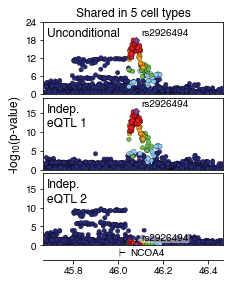

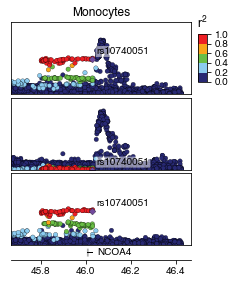

In [8]:
# plot
pos = int(eqtl_df['pval_nominal'].idxmin().split('_')[1])  # position of top bulk eQTL
window=400000
args = {'ymax':[24, 19, 19], 'xlim':np.array([pos-window, pos+window]), 'window':window, 'aw':2.5, 'ah':1}

ax = qtl.locusplot.plot_locus([eqtl_df, cond1_df, cond2_df], gene.id, variant_id1, annot, 
                              r2_s=r2_s1, rs_id=rs_id1, 
                              labels=['Unconditional', 'Indep.\neQTL 1', 'Indep.\neQTL 2'],
                              title='Shared in 5 cell types',
                              dr=0.025, colorbar=False, **args)
ax[0].set_ylabel(None)
ax[2].set_ylabel(None)
ax[-1].set_xlabel(None)
plt.savefig('pdfs/Fig7D_NCOA4_locus_plot1.pdf')

ax = qtl.locusplot.plot_locus([eqtl_df, cond1_df, cond2_df], gene.id, variant_id2, annot,
                              r2_s=r2_s2, rs_id=rs_id2, labels=[], title='Monocytes', dl=0.025, **args)
for i in ax:
    i.set_yticks([])
    i.set_ylabel(None)
ax[-1].set_xlabel(None)
plt.savefig('pdfs/Fig7D_NCOA4_locus_plot2.pdf')

### Panel E: GWAS colocalization

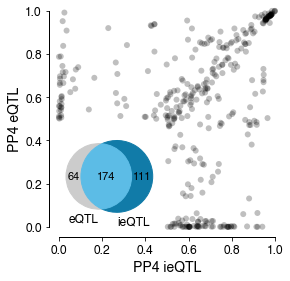

In [9]:
pp4_df = pd.read_csv('data/Fig7E_Whole_Blood.Neutrophils.eQTL_ieQTL_GWAS_coloc.txt', sep='\t')
cat_s = pp4_df['qtl'].value_counts()

args={'clip_on':False, 'edgecolor':'none'}

aw = 3
ah = aw
xspace=[1,0.25]
yspace=[0.75,0.25]
fw = aw + np.sum(xspace)
fh = ah + np.sum(yspace)
fig = plt.figure(facecolor=(1,1,1), figsize=(fw,fh))
ax = fig.add_axes([xspace[0]/fw, yspace[0]/fh, aw/fw, ah/fh])

ax.scatter(pp4_df['ieqtl_pp4'], pp4_df['eqtl_pp4'], c='k', alpha=0.25, **args)

ax2 = fig.add_axes([xspace[0]/fw, yspace[0]/fh, 1.4/fw, 1.4/fh])
v = venn2(ax=ax2, subsets={'01': cat_s['ieQTL'], '10': cat_s['eQTL'], '11': cat_s['both']},
         set_labels=('eQTL', 'ieQTL'), alpha=1)
v.get_patch_by_id('10').set_color(hsv_to_rgb([0.12, 0.0, 0.8]))
v.get_patch_by_id('01').set_color(hsv_to_rgb([0.55, 0.9, 0.66]))
v.get_patch_by_id('11').set_color(hsv_to_rgb([0.55, 0.6, 0.9]))
for i in v.subset_labels:
    i.set_fontsize(11)

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('PP4 ieQTL', fontsize=14)
ax.set_ylabel('PP4 eQTL',  fontsize=14)
qtl.plot.format_plot(ax, fontsize=12)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.savefig('pdfs/Fig7E_PP4_scatter.pdf')